## 1. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime
import random

import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization


from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model


## 2.Cargar la parte de extraccion de features de DenseNet121

Uno de los problemas es la resolución de las imágenes, estamos usando 32x32 pero el modelo base fue entrenado con imágenes de 224x224 por lo que necesitamos escalar nuestras imágenes.
Podemos lograr esto añadiendo una capa lambda en la parte superior del modelo base.

In [2]:
inputs = ks.Input(shape=(32, 32, 3))

In [3]:
upscale = ks.layers.Lambda(lambda x: tf.image.resize_with_pad(x, 224,224, method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [4]:
densenet121 = ks.applications.DenseNet121(include_top=False, weights='imagenet', input_tensor=upscale, input_shape=(224,224,3), pooling='max')

29089792/29084464 [==============================] - 0s 0us/step


In [5]:
densenet121.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
________________________________________________________________________________________

Como se puede ver en el summary, no tenemos capa Flatten de salida, así que creamos una Flatten basandonos en el output de la red neurona vgg. Y con Model() enganchamos una con la otra.

In [6]:
output = densenet121.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
densenet121_model = Model(densenet121.input, new_output_layer)

In [7]:
densenet121_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
______________________________________________________________________________________________

Veamos si son entrenables o no dichas capas

In [8]:
print("Is model trainable?", densenet121_model.trainable)

Is model trainable? True


In [9]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in densenet121_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb9add1e590>,input_1,True
1,<tensorflow.python.keras.layers.core.Lambda object at 0x7fb9acdf0990>,lambda,True
2,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb9acd54650>,zero_padding2d,True
3,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb9ec4da610>,conv1/conv,True
4,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb9acd6fdd0>,conv1/bn,True
...,...,...,...
425,<tensorflow.python.keras.layers.merge.Concatenate object at 0x7fb98ed4a810>,conv5_block16_concat,True
426,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb98ed50750>,bn,True
427,<tensorflow.python.keras.layers.core.Activation object at 0x7fb98ed5b950>,relu,True
428,<tensorflow.python.keras.layers.pooling.GlobalMaxPooling2D object at 0x7fb98ed50bd0>,max_pool,True


Vamos a activar como entrenables solo las convoluciones del bloque 4 para abajo, de ahí que hagamos el siguiente bucle.

In [10]:
entrenable = False

for layer in densenet121_model.layers [:149]:
  layer.trainable = entrenable

In [11]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in densenet121_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb9add1e590>,input_1,False
1,<tensorflow.python.keras.layers.core.Lambda object at 0x7fb9acdf0990>,lambda,False
2,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb9acd54650>,zero_padding2d,False
3,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb9ec4da610>,conv1/conv,False
4,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb9acd6fdd0>,conv1/bn,False
...,...,...,...
425,<tensorflow.python.keras.layers.merge.Concatenate object at 0x7fb98ed4a810>,conv5_block16_concat,True
426,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb98ed50750>,bn,True
427,<tensorflow.python.keras.layers.core.Activation object at 0x7fb98ed5b950>,relu,True
428,<tensorflow.python.keras.layers.pooling.GlobalMaxPooling2D object at 0x7fb98ed50bd0>,max_pool,True


## 3. Montemos la red de DenseNet121 + Clasificación

In [12]:
input_shape = densenet121_model.output_shape[1]

print('Tamaño de entrada:', input_shape)

Tamaño de entrada: 1024


In [13]:


model_with_densenet121 = ks.Sequential()

model_with_densenet121.add(densenet121_model)
model_with_densenet121.add(ks.layers.Dense(256, activation='relu'))
model_with_densenet121.add(BatchNormalization())
model_with_densenet121.add(ks.layers.Dropout(0.7))
model_with_densenet121.add(ks.layers.Dense(128, activation='relu'))
model_with_densenet121.add(BatchNormalization())
model_with_densenet121.add(ks.layers.Dropout(0.5))
model_with_densenet121.add(ks.layers.Dense(64, activation='relu'))
model_with_densenet121.add(BatchNormalization())
model_with_densenet121.add(ks.layers.Dropout(0.3))
model_with_densenet121.add(ks.layers.Dense(10, activation='softmax'))

model_with_densenet121.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

## 4. Creamos un optimizador


Como la red es muy compleja (más de 17 millones de parámetros), necesitamos un learning rate muy bajo, por eso creamos un Adam específico con un learning rate de 0.00002 (2e-5)

In [14]:
from tensorflow.keras.optimizers import Adam, SGD

In [15]:
new_adam = Adam(learning_rate=2e-5)
new_sgd = SGD(learning_rate=2e-5, momentum=0.9)

In [16]:
model_with_densenet121.compile(optimizer=new_adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 5. Definamos un callback para el Early Stopping

**Early Stopping**

Prevenimos el sobre ajuste parando cuando tras 15 epochs y el error de la validacion no decrementa (estamos en una plateau)

In [17]:
callback_val_loss = EarlyStopping(monitor="val_loss", patience=10)
callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=10)

## 6. Model Checkpoint
Montamos la monitorización para ir guardando el mejor modelo del entrenamiento con mejor accuracy de validación

In [18]:
modelcheckpoint = ModelCheckpoint('/tmp/chkpoint', monitor='val_accuracy', save_best_only=True)

## 7. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [19]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

170500096/170498071 [==============================] - 2s 0us/step


In [20]:
y_train_label = y_train

y_test
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

Obtenemos un array con todas las labels de CIFAR10

In [21]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


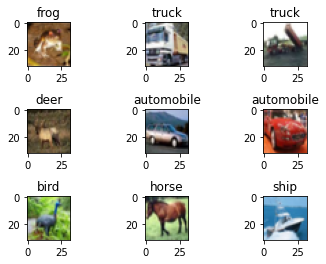

In [22]:

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_label[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos. Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método .get_cmap() de PlotLy con los nueve primeros números del dataset.

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [23]:
x_val = x_train[-10000:]
y_val = y_train[-10000:].ravel()

x_train = x_train[:-10000]
y_train = y_train[:-10000].ravel()

Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [24]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Validation: X=(10000, 32, 32, 3), y=(10000,)


##8. Preparamos el data augmentation

Como la red es muy compleja hemos de ir con cuidado con el batch_size de los generadores de imagenes, que no superen los 32 elementos

Entrenamiento

In [25]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True,
    vertical_flip=True
    )

train_generator = train_datagen.flow(
    x_train,  # Aquí hay que usar datos NO re-escalados... de ahi que no usemos x_train_rescaled!
    y_train, 
    batch_size=20
) 

**De validacion (test no lo necesita)**

La única modificación es un re-escalado, nada de modificaciones

In [26]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val, 
    y_val, 
    batch_size=20
)

## 9. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Al montar el data augmentation los steps per epochs y los validation steps hay que definirlos:

steps_per_epochs = total imagenes / batch_size del train generator

validation_steps = total imagenes validacion / batch_size del validation generator

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [27]:
t = time.perf_counter()

In [28]:
epochs = 200
steps = int(x_train.shape[0] / 20)
val_steps = int(x_val.shape[0] / 20)

history = model_with_densenet121.fit(train_generator, epochs=epochs, steps_per_epoch=steps,
                             callbacks=[callback_val_loss, callback_val_accuracy, modelcheckpoint],
                             validation_data=validation_generator, validation_steps = val_steps)

Epoch 1/200
2000/2000 [==============================] - 184s 84ms/step - loss: 3.0999 - accuracy: 0.1205 - val_loss: 1.9043 - val_accuracy: 0.3430
Epoch 2/200
2000/2000 [==============================] - 168s 84ms/step - loss: 2.5093 - accuracy: 0.2078 - val_loss: 1.3801 - val_accuracy: 0.5362
Epoch 3/200
2000/2000 [==============================] - 167s 84ms/step - loss: 2.0025 - accuracy: 0.3247 - val_loss: 1.0110 - val_accuracy: 0.6652
Epoch 4/200
2000/2000 [==============================] - 169s 84ms/step - loss: 1.6291 - accuracy: 0.4397 - val_loss: 0.8052 - val_accuracy: 0.7351
Epoch 5/200
2000/2000 [==============================] - 170s 85ms/step - loss: 1.4069 - accuracy: 0.5260 - val_loss: 0.6787 - val_accuracy: 0.7830
Epoch 6/200
2000/2000 [==============================] - 173s 87ms/step - loss: 1.1963 - accuracy: 0.6023 - val_loss: 0.5609 - val_accuracy: 0.8179
Epoch 7/200
2000/2000 [==============================] - 173s 87ms/step - loss: 1.0753 - accuracy: 0.6478 - val_

In [29]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 2:23:31.507310


## 7. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [30]:
_, acc = model_with_densenet121.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 93.010


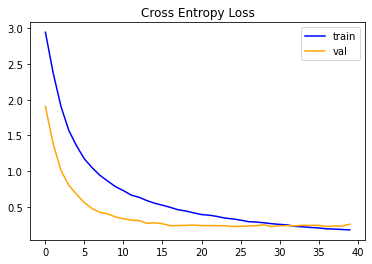

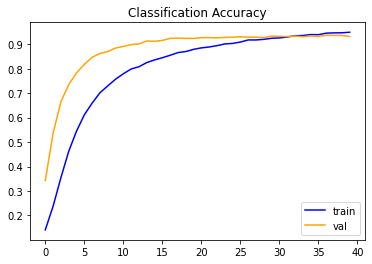

In [31]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

Vemos que a partir del epoch 20, el modelo empieza a tener overfitting.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [32]:
predictions = model_with_densenet121.predict(x_test)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [33]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


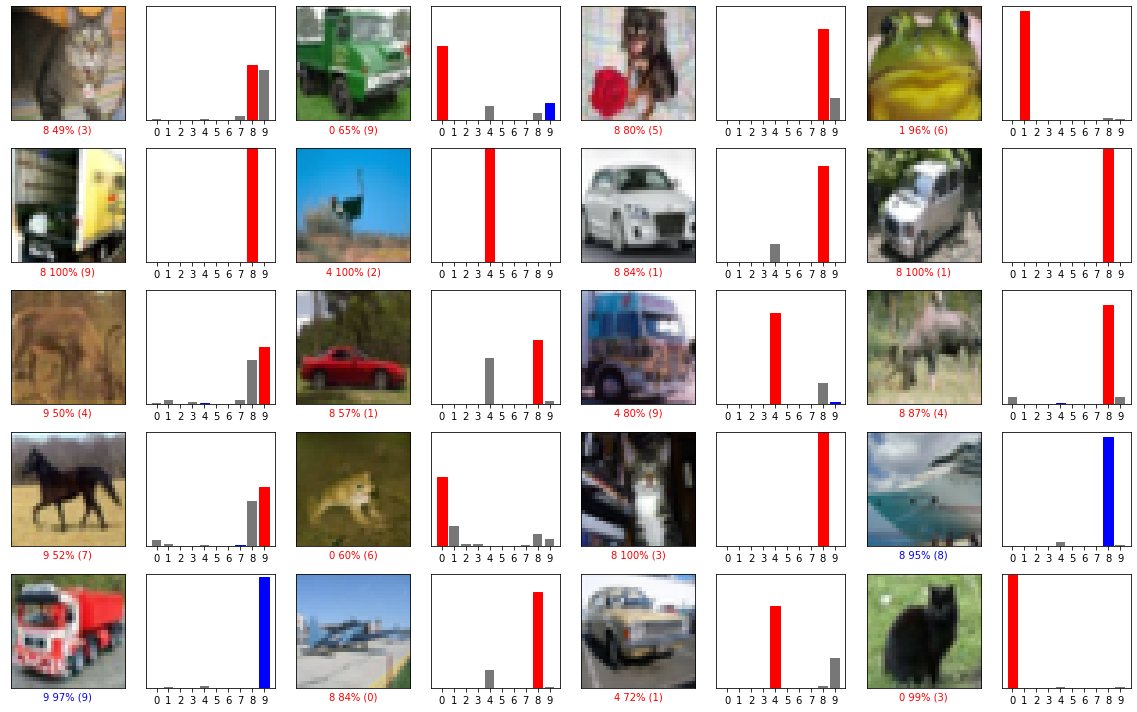

In [34]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 8. Guardamos el mejor modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [35]:
model_with_densenet121.save("model_with_finetunning_transfer_learning_densenet121_plus_data_augmentation.h5")